In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df['State/UT'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Delhi',
       'Dadra and Nagar Haveli and Daman and Diu', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object)

In [4]:
gdf = gpd.read_file("INDIA_STATES.geojson")


In [5]:
gdf.STNAME_SH.unique()

array(['Arunachal Pradesh', 'Assam', 'Chandigarh', 'Chhattisgarh',
       'Delhi', 'Goa', 'Haryana', 'Himachal Pradesh', 'Jharkhand',
       'Karnataka', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tripura', 'Uttarakhand',
       'Telangana', 'Andaman & Nicobar', 'Bihar', 'Gujarat', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Odisha', 'Tamil Nadu',
       'Uttar Pradesh', 'West Bengal', 'Andhra Pradesh', 'Puducherry',
       'Maharashtra', 'Daman & Diu', 'Dadra & Nagar Haveli', 'Ladakh',
       'Jammu & Kashmir'], dtype=object)

In [6]:
state_name_map = {
    'Andaman and Nicobar Islands': 'Andaman & Nicobar',
    'Dadra and Nagar Haveli and Daman and Diu': 'DNHDD',  # prioritize one; see note below
    'Jammu and Kashmir': 'Jammu & Kashmir',

}
df['State/UT'] = df['State/UT'].replace(state_name_map)


In [7]:
gdf.columns

Index(['STNAME', 'STCODE11', 'STNAME_SH', 'Shape_Length', 'Shape_Area',
       'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol',
       'MinSimpTol', 'geometry'],
      dtype='object')

In [8]:

# Replace STNAME values to merge
gdf['STNAME_SH'] = gdf['STNAME_SH'].replace({
    'Dadra & Nagar Haveli': 'Daman & Diu'
    
})

# Dissolve rows with same state name into a single geometry
gdf = gdf.dissolve(by='STNAME_SH', as_index=False)
gdf['STNAME_SH'] = gdf['STNAME_SH'].replace('Daman & Diu', 'DNHDD')



In [9]:
gdf.STNAME_SH.unique()

array(['Andaman & Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'DNHDD', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object)

In [10]:
# merge dataframes on state names
final = gdf.merge(df, left_on='STNAME_SH', right_on='State/UT')
final = final.rename(columns={'Prevalence of anemia among all women age 15-49 years (%)': 'anemia'})


In [11]:
final.columns

Index(['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length',
       'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng',
       'MaxSimpTol', 'MinSimpTol', 'Sl. No.', 'State/UT', 'anemia'],
      dtype='object')

DataFrame shape: (36, 15)
Columns: ['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length', 'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol', 'MinSimpTol', 'Sl. No.', 'State/UT', 'anemia']
Anemia values:
 count    36.000000
mean     53.994444
std      13.573376
min      25.800000
25%      46.500000
50%      54.900000
75%      62.750000
max      92.800000
Name: anemia, dtype: float64


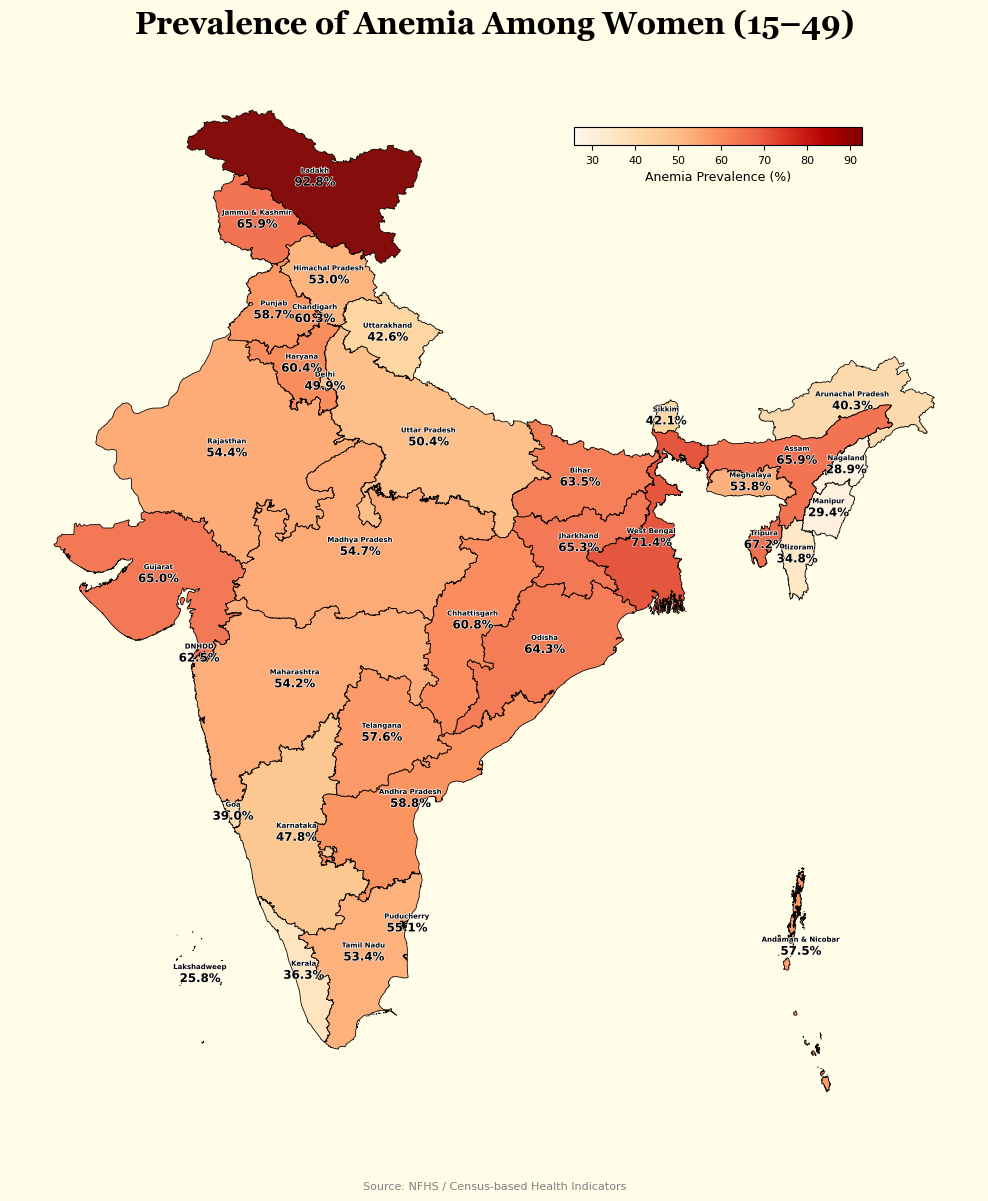

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_palette("husl")
plt.style.use('default')

def create_anemia_map(final_df):
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#fffde7')  # Light background

    # Map axis
    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#fffde7')

    # Normalize and colormap (new scheme)
    norm = Normalize(vmin=final_df['anemia'].min(), vmax=final_df['anemia'].max())
    cmap = cm.get_cmap('OrRd')  # Changed to YlGnBu

    # Assign color to each state
    colors = final_df['anemia'].apply(lambda x: cmap(norm(x)) if pd.notnull(x) else (0.9, 0.9, 0.9, 1.0))

    # Plot map
    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='black',
        linewidth=0.6,
        alpha=0.95
    )

    # Add state labels and anemia annotations
    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            # State name
            ax_map.text(point.x, point.y + 0.2, row['STNAME_SH'],
                        ha='center', fontsize=5, fontweight='bold', color='black',
                        path_effects=[path_effects.withStroke(linewidth=1, foreground="white")])
            # Anemia value
            if pd.notnull(row['anemia']):
                ax_map.text(point.x, point.y - 0.2, f"{row['anemia']:.1f}%",
                            ha='center', fontsize=8.5,fontweight='bold', color='black',
                            path_effects=[path_effects.withStroke(linewidth=0.8, foreground="white")])

    # Title
    ax_map.set_title(
        'Prevalence of Anemia Among Women (15–49)',
        fontsize=22, fontweight='bold', fontname='Georgia', pad=20
    )
    ax_map.set_axis_off()

    # Horizontal colorbar (top-right corner)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar_ax = fig.add_axes([0.55, 0.88, 0.18, 0.015])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('Anemia Prevalence (%)', fontsize=9)

    # Footer
    plt.figtext(0.5, 0.01,
                'Source: NFHS / Census-based Health Indicators',
                ha='center', fontsize=8, color='gray')

    plt.tight_layout()
    return fig

# Debug (optional)
def debug_data(final_df):
    print("DataFrame shape:", final_df.shape)
    print("Columns:", final_df.columns.tolist())
    print("Anemia values:\n", final_df['anemia'].describe())

# === Execution ===
if __name__ == "__main__":
    debug_data(final)  
    map_fig = create_anemia_map(final)

    # Save high-resolution PNG
    map_fig.savefig('anemia_map.png', dpi=300, bbox_inches='tight', facecolor=map_fig.get_facecolor())

    plt.show()


ANEMIA MAP DATA SUMMARY
DataFrame shape: (36, 15)
Columns: ['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length', 'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol', 'MinSimpTol', 'Sl. No.', 'State/UT', 'anemia']

Anemia Statistics:
count    36.000000
mean     53.994444
std      13.573376
min      25.800000
25%      46.500000
50%      54.900000
75%      62.750000
max      92.800000
Name: anemia, dtype: float64

States with highest anemia rates:
          STNAME_SH  anemia
17           Ladakh    92.8
35      West Bengal    71.4
32          Tripura    67.2
3             Assam    65.9
13  Jammu & Kashmir    65.9

States with lowest anemia rates:
      STNAME_SH  anemia
18  Lakshadweep    25.8
24     Nagaland    28.9
21      Manipur    29.4
23      Mizoram    34.8
16       Kerala    36.3


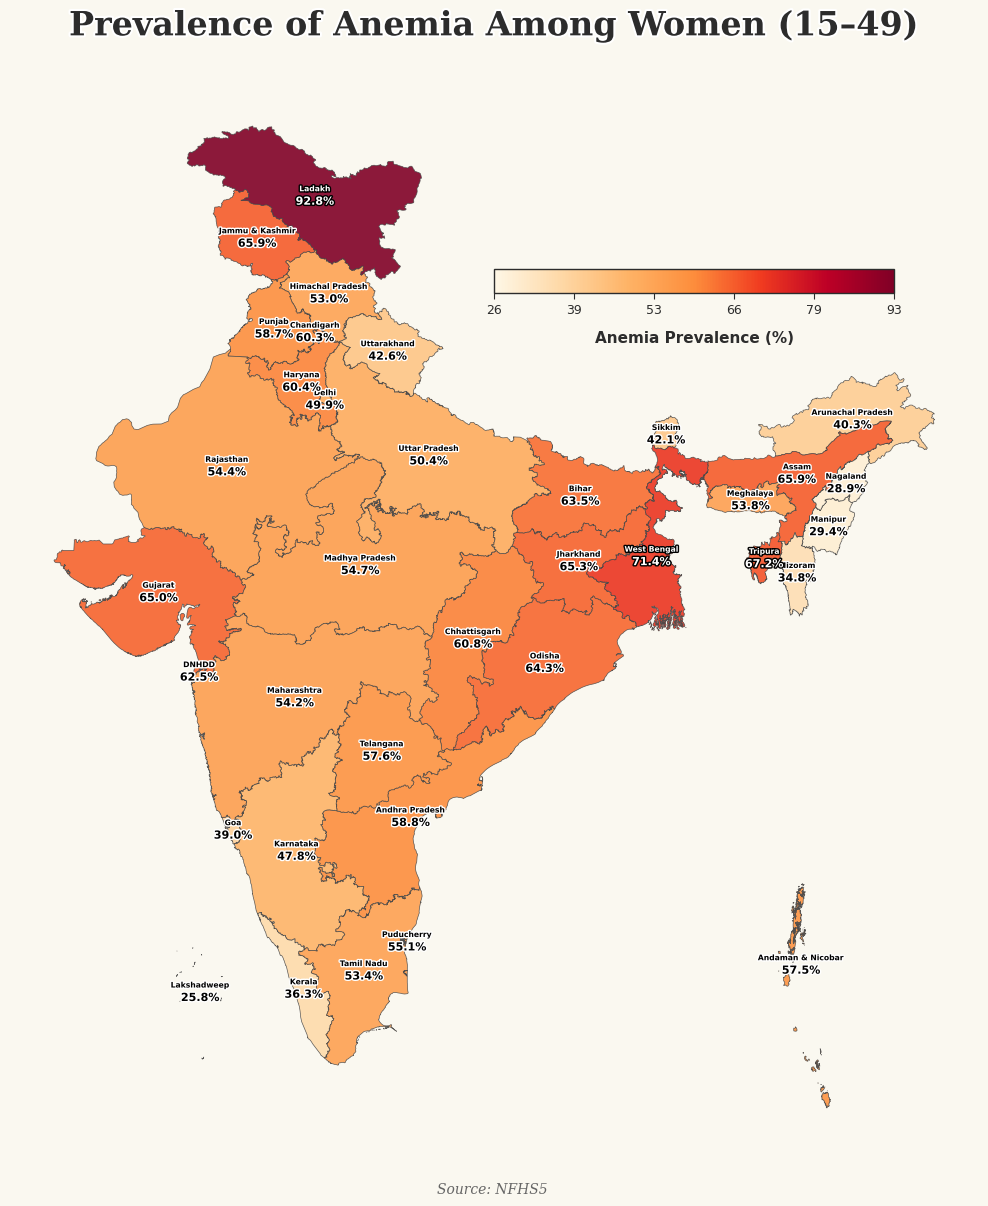

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')

def create_anemia_map(final_df):
    # Create figure with cream background
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')  # Warm cream background

    # Map axis
    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    # Create custom colormap - warm cream to deep red
    colors_list = ['#fef7e6', '#fed8a6', '#feb366', '#fd8d3c', '#f03b20', '#bd0026', '#800026']
    custom_cmap = LinearSegmentedColormap.from_list('anemia_cmap', colors_list, N=256)
    
    # Normalize values
    norm = Normalize(vmin=final_df['anemia'].min(), vmax=final_df['anemia'].max())

    # Assign color to each state
    colors = final_df['anemia'].apply(lambda x: custom_cmap(norm(x)) if pd.notnull(x) else (0.95, 0.95, 0.95, 1.0))

    # Plot map with subtle shadow effect
    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='#4a4a4a',  # Dark gray borders
        linewidth=0.5,
        alpha=0.9
    )

    # Function to determine text color based on background
    def get_text_color(anemia_value):
        if pd.isnull(anemia_value):
            return 'black'
        normalized_val = norm(anemia_value)
        # Use white text for dark backgrounds (high anemia values)
        return 'white' if normalized_val > 0.6 else 'black'

    # Add state labels and anemia annotations with adaptive colors
    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            text_color = get_text_color(row['anemia'])
            outline_color = 'black' if text_color == 'white' else 'white'
            
            # State name with adaptive coloring
            text_state = ax_map.text(
                point.x, point.y + 0.2, row['STNAME_SH'],
                ha='center', va='center', fontsize=5.5, fontweight='bold', 
                color=text_color, fontfamily='sans-serif',
                path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
            )
            
            # Anemia value with adaptive coloring
            if pd.notnull(row['anemia']):
                text_value = ax_map.text(
                    point.x, point.y - 0.2, f"{row['anemia']:.1f}%",
                    ha='center', va='center', fontsize=8, fontweight='bold', 
                    color=text_color, fontfamily='sans-serif',
                    path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
                )

    # Enhanced title with shadow effect
    title = ax_map.set_title(
        'Prevalence of Anemia Among Women (15–49)',
        fontsize=24, fontweight='bold', fontfamily='serif', 
        pad=30, color='#2c2c2c'
    )
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_map.set_axis_off()

    # Enhanced horizontal colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm._A = []
    
    # Colorbar with border
    cbar_ax = fig.add_axes([0.50, 0.77, 0.25, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    
    # Style the colorbar
    cbar.ax.tick_params(labelsize=9, colors='#2c2c2c', length=4)
    cbar.set_label('Anemia Prevalence (%)', fontsize=11, fontweight='bold', 
                   color='#2c2c2c', labelpad=10)
    
    # Add colorbar border
    cbar.outline.set_edgecolor('#2c2c2c')
    cbar.outline.set_linewidth(1)
    
    # Add tick marks for better readability
    tick_positions = np.linspace(final_df['anemia'].min(), final_df['anemia'].max(), 6)
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([f'{x:.0f}' for x in tick_positions])

    # Enhanced footer with better styling
    plt.figtext(0.5, 0.02,
                'Source: NFHS5 ',
                ha='center', fontsize=10, color='#666666', 
                style='italic', fontfamily='serif')

    # Add subtle grid lines for Indian states (optional)
    ax_map.grid(True, alpha=0.1, color='gray', linewidth=0.5)

    plt.tight_layout()
    return fig

# Enhanced debug function
def debug_data(final_df):
    print("=" * 50)
    print("ANEMIA MAP DATA SUMMARY")
    print("=" * 50)
    print(f"DataFrame shape: {final_df.shape}")
    print(f"Columns: {final_df.columns.tolist()}")
    print("\nAnemia Statistics:")
    print(final_df['anemia'].describe())
    print(f"\nStates with highest anemia rates:")
    print(final_df.nlargest(5, 'anemia')[['STNAME_SH', 'anemia']])
    print(f"\nStates with lowest anemia rates:")
    print(final_df.nsmallest(5, 'anemia')[['STNAME_SH', 'anemia']])
    print("=" * 50)

# === Execution ===
if __name__ == "__main__":
    debug_data(final)  
    map_fig = create_anemia_map(final)

    # Save high-resolution images in multiple formats
    map_fig.savefig('anemia_map_enhanced.png', dpi=300, bbox_inches='tight', 
                   facecolor=map_fig.get_facecolor(), edgecolor='none')
    map_fig.savefig('anemia_map_enhanced.pdf', bbox_inches='tight', 
                   facecolor=map_fig.get_facecolor(), edgecolor='none')

    plt.show()

ANEMIA MAP DATA SUMMARY
DataFrame shape: (36, 15)
Columns: ['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length', 'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol', 'MinSimpTol', 'Sl. No.', 'State/UT', 'anemia']

Anemia Statistics:
count    36.000000
mean     53.994444
std      13.573376
min      25.800000
25%      46.500000
50%      54.900000
75%      62.750000
max      92.800000
Name: anemia, dtype: float64

States with highest anemia rates:
          STNAME_SH  anemia
17           Ladakh    92.8
35      West Bengal    71.4
32          Tripura    67.2
3             Assam    65.9
13  Jammu & Kashmir    65.9

States with lowest anemia rates:
      STNAME_SH  anemia
18  Lakshadweep    25.8
24     Nagaland    28.9
21      Manipur    29.4
23      Mizoram    34.8
16       Kerala    36.3

Distribution by bins:
0-20%: 0 states
20-40%: 6 states
40-60%: 17 states
60-80%: 12 states
80-100%: 1 states
80-100%: 1 states


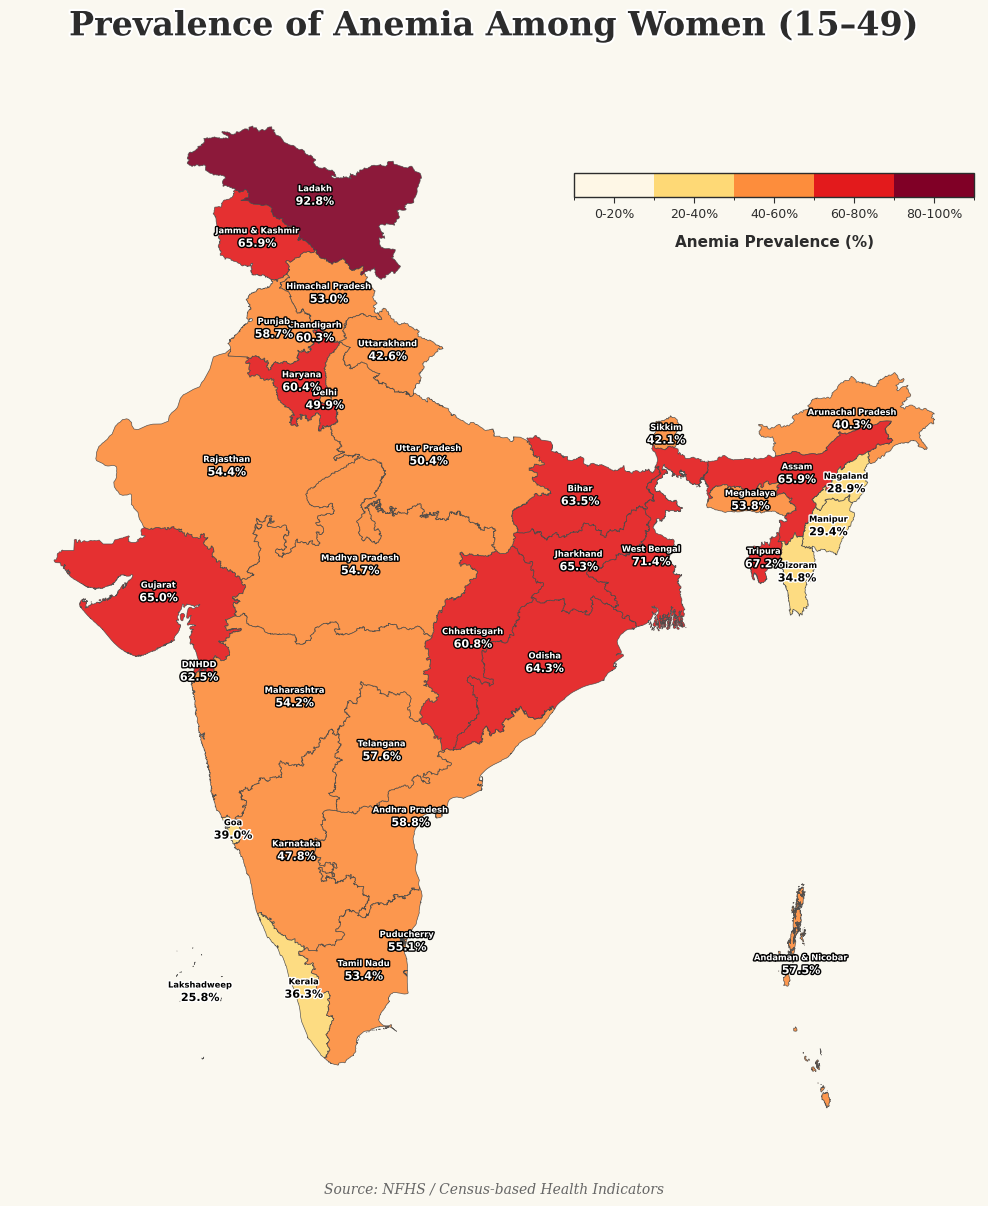

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')

def create_anemia_map(final_df):
    # Create figure with cream background
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')  # Warm cream background

    # Map axis
    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    # Define discrete bins and colors
    bins = [0, 20, 40, 60, 80, 100]
    colors_list = ['#fef7e6', '#fed976', '#fd8d3c', '#e31a1c', '#800026']
    bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    
    # Create discrete colormap
    custom_cmap = LinearSegmentedColormap.from_list('anemia_cmap', colors_list, N=len(colors_list))
    norm = BoundaryNorm(bins, custom_cmap.N)

    # Assign color to each state
    colors = final_df['anemia'].apply(lambda x: custom_cmap(norm(x)) if pd.notnull(x) else (0.95, 0.95, 0.95, 1.0))

    # Plot map with subtle shadow effect
    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='#4a4a4a',  # Dark gray borders
        linewidth=0.5,
        alpha=0.9
    )

    # Function to determine text color based on background
    def get_text_color(anemia_value):
        if pd.isnull(anemia_value):
            return 'black'
        # Determine which bin the value falls into
        bin_index = np.digitize(anemia_value, bins) - 1
        bin_index = max(0, min(bin_index, len(colors_list) - 1))  # Clamp to valid range
        # Use white text for darker backgrounds (bins 2, 3, 4)
        return 'white' if bin_index >= 2 else 'black'

    # Add state labels and anemia annotations with adaptive colors
    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            text_color = get_text_color(row['anemia'])
            outline_color = 'black' if text_color == 'white' else 'white'
            
            # State name with adaptive coloring
            text_state = ax_map.text(
                point.x, point.y + 0.2, row['STNAME_SH'],
                ha='center', va='center', fontsize=6, fontweight='bold', 
                color=text_color, fontfamily='sans-serif',
                path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
            )
            
            # Anemia value with adaptive coloring
            if pd.notnull(row['anemia']):
                text_value = ax_map.text(
                    point.x, point.y - 0.2, f"{row['anemia']:.1f}%",
                    ha='center', va='center', fontsize=8, fontweight='bold', 
                    color=text_color, fontfamily='sans-serif',
                    path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
                )

    # Enhanced title with shadow effect
    title = ax_map.set_title(
        'Prevalence of Anemia Among Women (15–49)',
        fontsize=24, fontweight='bold', fontfamily='serif', 
        pad=30, color='#2c2c2c'
    )
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_map.set_axis_off()

    # Enhanced horizontal colorbar with discrete bins
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm._A = []
    
    # Colorbar with border
    cbar_ax = fig.add_axes([0.55, 0.85, 0.25, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', 
                       boundaries=bins, ticks=bins[:-1])
    
    # Style the colorbar
    cbar.ax.tick_params(labelsize=9, colors='#2c2c2c', length=4)
    cbar.set_label('Anemia Prevalence (%)', fontsize=11, fontweight='bold', 
                   color='#2c2c2c', labelpad=10)
    
    # Set custom tick labels for bins
    tick_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(bin_labels)
    
    # Add colorbar border
    cbar.outline.set_edgecolor('#2c2c2c')
    cbar.outline.set_linewidth(1)

    # Enhanced footer with better styling
    plt.figtext(0.5, 0.02,
                'Source: NFHS / Census-based Health Indicators',
                ha='center', fontsize=10, color='#666666', 
                style='italic', fontfamily='serif')

    # Add subtle grid lines for Indian states (optional)
    ax_map.grid(True, alpha=0.1, color='gray', linewidth=0.5)

    plt.tight_layout()
    return fig

# Enhanced debug function
def debug_data(final_df):
    # Define bins and labels for debug output
    bins = [0, 20, 40, 60, 80, 100]
    bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    
    print("=" * 50)
    print("ANEMIA MAP DATA SUMMARY")
    print("=" * 50)
    print(f"DataFrame shape: {final_df.shape}")
    print(f"Columns: {final_df.columns.tolist()}")
    print("\nAnemia Statistics:")
    print(final_df['anemia'].describe())
    print(f"\nStates with highest anemia rates:")
    print(final_df.nlargest(5, 'anemia')[['STNAME_SH', 'anemia']])
    print(f"\nStates with lowest anemia rates:")
    print(final_df.nsmallest(5, 'anemia')[['STNAME_SH', 'anemia']])
    print(f"\nDistribution by bins:")
    for i in range(len(bins)-1):
        count = len(final_df[(final_df['anemia'] >= bins[i]) & (final_df['anemia'] < bins[i+1])])
        print(f"{bin_labels[i]}: {count} states")
    # Handle the last bin (including upper bound)
    count = len(final_df[final_df['anemia'] >= bins[-2]])
    print(f"{bin_labels[-1]}: {count} states")
    print("=" * 50)

# === Execution ===
if __name__ == "__main__":
    debug_data(final)  
    map_fig = create_anemia_map(final)

    # Save high-resolution images in multiple formats
    map_fig.savefig('anemia_map_enhanced.png', dpi=300, bbox_inches='tight', 
                   facecolor=map_fig.get_facecolor(), edgecolor='none')
    map_fig.savefig('anemia_map_enhanced.pdf', bbox_inches='tight', 
                   facecolor=map_fig.get_facecolor(), edgecolor='none')

    plt.show()

ANEMIA MAP DATA SUMMARY (QUANTILE-BASED)
DataFrame shape: (36, 15)
Columns: ['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length', 'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol', 'MinSimpTol', 'Sl. No.', 'State/UT', 'anemia']

Anemia Statistics:
count    36.000000
mean     53.994444
std      13.573376
min      25.800000
25%      46.500000
50%      54.900000
75%      62.750000
max      92.800000
Name: anemia, dtype: float64

Quantile Boundaries:
Q1 (25th percentile): 46.5%
Q2 (50th percentile/Median): 54.9%
Q3 (75th percentile): 62.8%

States with highest anemia rates:
          STNAME_SH  anemia
17           Ladakh    92.8
35      West Bengal    71.4
32          Tripura    67.2
3             Assam    65.9
13  Jammu & Kashmir    65.9

States with lowest anemia rates:
      STNAME_SH  anemia
18  Lakshadweep    25.8
24     Nagaland    28.9
21      Manipur    29.4
23      Mizoram    34.8
16       Kerala    36.3

Distribution by Quartiles (each shou

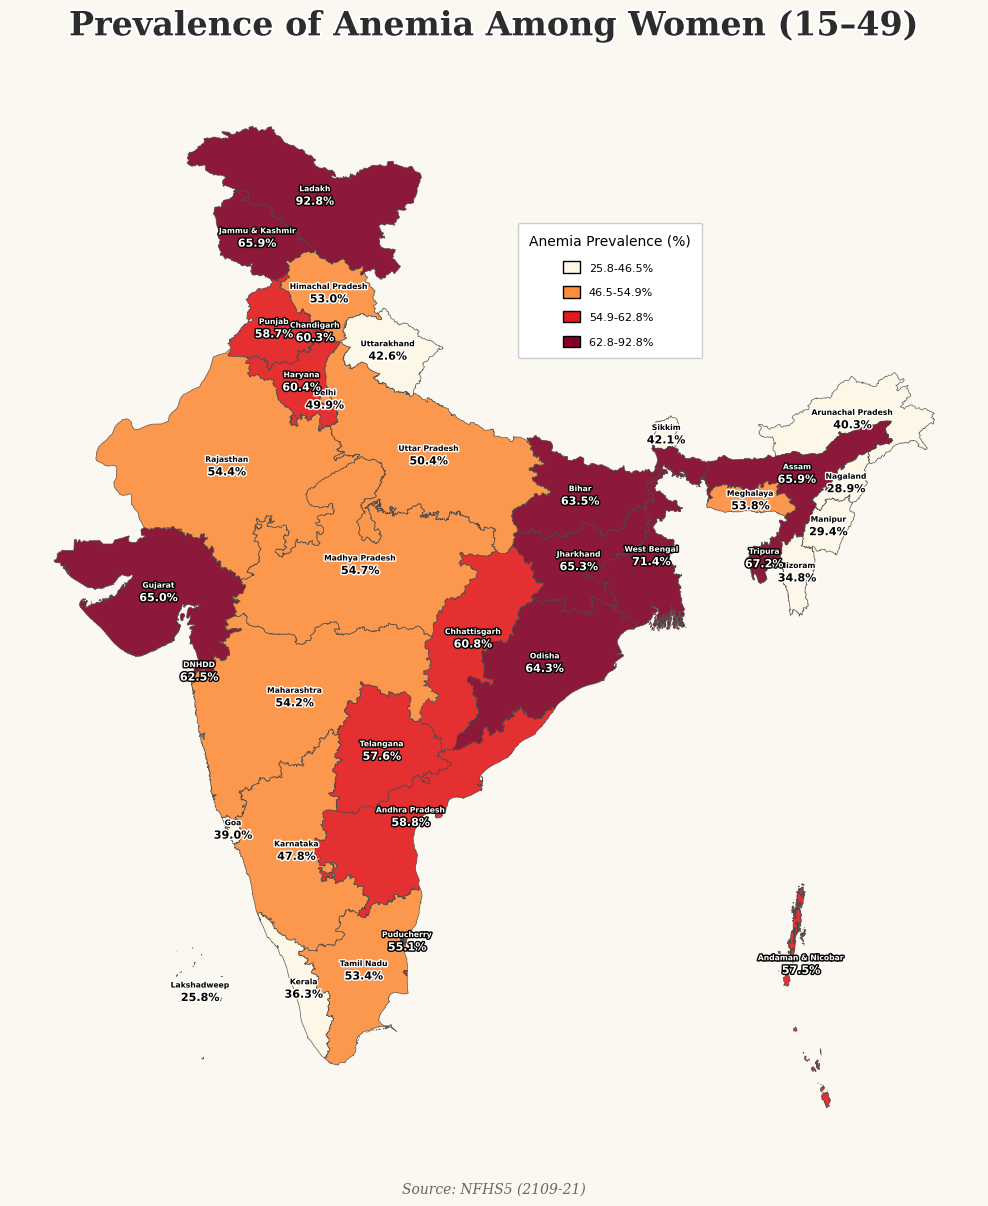

In [15]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

def create_anemia_map(final_df):
    # Create figure with cream background
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')  # Warm cream background

    # Map axis
    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    # Create 4 quantiles based on anemia values
    quantiles = final_df['anemia'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
    quantiles = np.round(quantiles, 1)
    
    # Define colors for quantiles
    colors_list = ['#fef7e6', '#fd8d3c', '#e31a1c', '#800026']
    quantile_labels = [
        f'{quantiles[0]:.1f}-{quantiles[1]:.1f}%',
        f'{quantiles[1]:.1f}-{quantiles[2]:.1f}%',
        f'{quantiles[2]:.1f}-{quantiles[3]:.1f}%',
        f'{quantiles[3]:.1f}-{quantiles[4]:.1f}% '
    ]

    # Assign quantile bin to each state
    def assign_color(value):
        if pd.isnull(value):
            return (0.95, 0.95, 0.95, 1.0)  # light gray for NaNs
        for i in range(4):
            lower = quantiles[i]
            upper = quantiles[i + 1]
            if i == 0:
                if lower <= value <= upper:
                    return colors_list[i]
            else:
                if lower < value <= upper:
                    return colors_list[i]
        return colors_list[-1]

    final_df['color'] = final_df['anemia'].apply(assign_color)

    # Plot the map
    final_df.plot(
        ax=ax_map,
        color=final_df['color'],
        edgecolor='#4a4a4a',
        linewidth=0.5,
        alpha=0.9
    )

    # Function to determine text color
    def get_text_color(anemia_value):
        if pd.isnull(anemia_value):
            return 'black'
        q = np.digitize(anemia_value, quantiles) - 1
        q = max(0, min(q, len(colors_list) - 1))
        return 'white' if q >= 2 else 'black'

    # Add state labels and anemia annotations
    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            text_color = get_text_color(row['anemia'])
            outline_color = 'black' if text_color == 'white' else 'white'

            # State abbreviation
            ax_map.text(
                point.x, point.y + 0.2, row['STNAME_SH'],
                ha='center', va='center', fontsize=5.5, fontweight='bold',
                color=text_color, fontfamily='sans-serif',
                path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
            )

            # Anemia %
            if pd.notnull(row['anemia']):
                ax_map.text(
                    point.x, point.y - 0.2, f"{row['anemia']:.1f}%",
                    ha='center', va='center', fontsize=8, fontweight='bold',
                    color=text_color, fontfamily='sans-serif',
                    path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
                )

    # Title with shadow
    title = ax_map.set_title(
        'Prevalence of Anemia Among Women (15–49)',
        fontsize=24, fontweight='bold', fontfamily='serif',
        pad=30, color='#2c2c2c'
    )
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

    ax_map.set_axis_off()

    # ===== Box Legend instead of Colorbar =====
    legend_patches = [Patch(facecolor=colors_list[i], edgecolor='black', label=quantile_labels[i])
                      for i in range(len(colors_list))]

    ax_map.legend(
    handles=legend_patches,
    title='Anemia Prevalence (%)',
    title_fontsize=10,
    fontsize=8,
    loc='upper right',
    bbox_to_anchor=(0.72, 0.87),  # <--- move left by adjusting first value (default is ~1.0)
    frameon=True,
    framealpha=1,
    borderpad=1,
    labelspacing=1.2,
    handlelength=1.5,
    handleheight=1.2
)


    # Footer
    plt.figtext(0.5, 0.02,
                'Source: NFHS5 (2109-21)',
                ha='center', fontsize=10, color='#666666',
                style='italic', fontfamily='serif')

    plt.tight_layout()
    return fig


def debug_data(final_df):
    quantiles = final_df['anemia'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
    quantiles = np.round(quantiles, 1)

    print("=" * 60)
    print("ANEMIA MAP DATA SUMMARY (QUANTILE-BASED)")
    print("=" * 60)
    print(f"DataFrame shape: {final_df.shape}")
    print(f"Columns: {final_df.columns.tolist()}")
    print("\nAnemia Statistics:")
    print(final_df['anemia'].describe())

    print(f"\nQuantile Boundaries:")
    print(f"Q1 (25th percentile): {quantiles[1]:.1f}%")
    print(f"Q2 (50th percentile/Median): {quantiles[2]:.1f}%") 
    print(f"Q3 (75th percentile): {quantiles[3]:.1f}%")

    print(f"\nStates with highest anemia rates:")
    print(final_df.nlargest(5, 'anemia')[['STNAME_SH', 'anemia']])
    print(f"\nStates with lowest anemia rates:")
    print(final_df.nsmallest(5, 'anemia')[['STNAME_SH', 'anemia']])

    print(f"\nDistribution by Quartiles (each should have ~25% of states):")
    for i in range(len(quantiles)-1):
        if i == 0:
            subset = final_df[(final_df['anemia'] >= quantiles[i]) & (final_df['anemia'] <= quantiles[i+1])]
        else:
            subset = final_df[(final_df['anemia'] > quantiles[i]) & (final_df['anemia'] <= quantiles[i+1])]
        
        count = len(subset)
        percentage = (count / len(final_df)) * 100
        quartile_name = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'][i]
        print(f"{quartile_name}: {quantiles[i]:.1f}-{quantiles[i+1]:.1f}% → {count} states ({percentage:.1f}%)")

        if count > 0:
            examples = subset['STNAME_SH'].head(3).tolist()
            print(f"   Examples: {', '.join(examples)}")

    print("=" * 60)

# === Execution ===
if __name__ == "__main__":
    debug_data(final)  # Make sure 'final' DataFrame is already loaded with 'geometry', 'anemia', and 'STNAME_SH'
    map_fig = create_anemia_map(final)

    # Save outputs
    map_fig.savefig('anemia_map_enhanced.png', dpi=300, bbox_inches='tight',
                   facecolor=map_fig.get_facecolor(), edgecolor='none')
    map_fig.savefig('anemia_map_enhanced.pdf', bbox_inches='tight',
                   facecolor=map_fig.get_facecolor(), edgecolor='none')

    plt.show()
